<a href="https://colab.research.google.com/github/abegpatel/miles-travel-forecasting-using-rnn/blob/master/03_RNN_miles_travel_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Miles_Traveled.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [ ]:
df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


In [ ]:
df.columns=['Value']

In [ ]:
df

,Value
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0
...,...
2018-08-01,286608.0
2018-09-01,260595.0
2018-10-01,282174.0


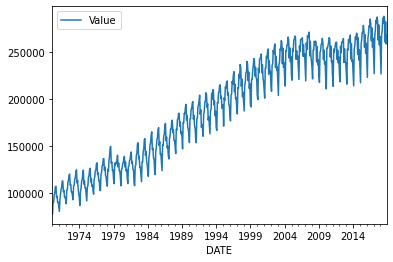

In [ ]:
df.plot()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


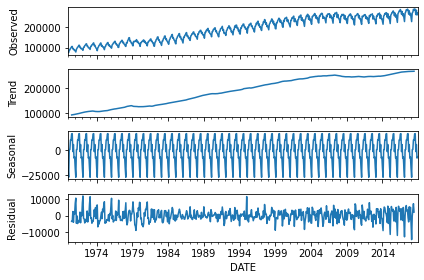

In [ ]:
results = seasonal_decompose(df['Value'])
results.plot();

**Train Test Split**

In [ ]:
len(df)

588

In [ ]:
train_len = len(df)-12

In [ ]:
train = df.iloc[:train_len]
test = df.iloc[train_len:]

**Scale Data**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

**# Time Series Generator**

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [ ]:
n_input = 24
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

**Create the Model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
 #fit model
model.fit_generator(generator,epochs=30)

Epoch 1/30
552/552 [==============================] - 8s 15ms/step - loss: 0.0147
Epoch 2/30
552/552 [==============================] - 8s 14ms/step - loss: 0.0064
Epoch 3/30
552/552 [==============================] - 8s 14ms/step - loss: 0.0059
Epoch 4/30
552/552 [==============================] - 8s 14ms/step - loss: 0.0056
Epoch 5/30
552/552 [==============================] - 8s 14ms/step - loss: 0.0049
Epoch 6/30
552/552 [==============================] - 8s 14ms/step - loss: 0.0037
Epoch 7/30
552/552 [==============================] - 8s 14ms/step - loss: 0.0025
Epoch 8/30
552/552 [==============================] - 8s 14ms/step - loss: 0.0021
Epoch 9/30
552/552 [==============================] - 8s 14ms/step - loss: 0.0017
Epoch 10/30
552/552 [==============================] - 8s 14ms/step - loss: 0.0018
Epoch 11/30
552/552 [==============================] - 8s 14ms/step - loss: 0.0016
Epoch 12/30
552/552 [==============================] - 8s 14ms/step - loss: 0.0014
Epoch 13/30
5

In [ ]:
model.history.history.keys()

dict_keys(['loss'])

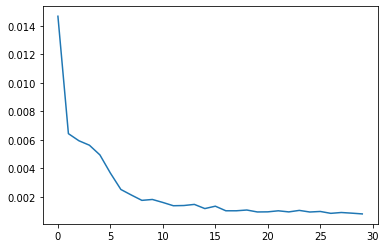

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

**Evaluate on Test Data**

In [ ]:
first_eval_batch = scaled_train[-12:]

In [ ]:
first_eval_batch

array([[0.79630397],
       [0.71226435],
       [0.90477416],
       [0.93121043],
       [0.98386382],
       [0.96757519],
       [1.        ],
       [0.9801859 ],
       [0.8824684 ],
       [0.95995255],
       [0.85883345],
       [0.90086755]])

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

**Generate predictions into the same time stamps as the test set**

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

**Inverse Transformations and Compare¶**

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions

array([[249247.12832665],
       [239757.49079686],
       [269787.76046705],
       [275810.32901949],
       [286093.55651861],
       [286251.08345819],
       [292321.40678215],
       [287532.66789007],
       [274798.29568863],
       [281867.96611387],
       [266171.29674858],
       [270024.40744203]])

**Create a new dataframe that has both the original test values and your predictions for them.**

In [ ]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,Value,Predictions
DATE,,
2018-01-01,245695.0,249247.128327
2018-02-01,226660.0,239757.490797
2018-03-01,268480.0,269787.760467
2018-04-01,272475.0,275810.329019
2018-05-01,286164.0,286093.556519
2018-06-01,280877.0,286251.083458
2018-07-01,288145.0,292321.406782
2018-08-01,286608.0,287532.667890
2018-09-01,260595.0,274798.295689


**TASK: Plot out the test set against your own predicted values.**

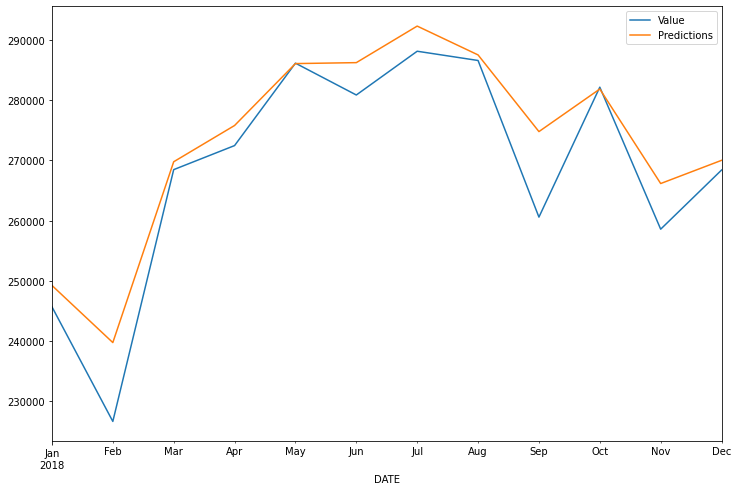

In [ ]:
test.plot(figsize=(12,8))

**Saving Models**
**TASK: Optional, Save your model!**

In [ ]:
model.save('solutions_model.h5')